In [282]:
%matplotlib inline

import math

import cirq
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.optimize import minimize

# Introduction


# Defining our first graph

To make sure the following code works properly, we will choose a linear graph of 5 nodes as [lucaman99](https://lucaman99.github.io/new_blog/2020/mar16.html) did in his tutorial and set all the weights to 1 $(w_{ij}=1)$.  

Later on, we will try different graphs with different weights and see if we also get the expected result.

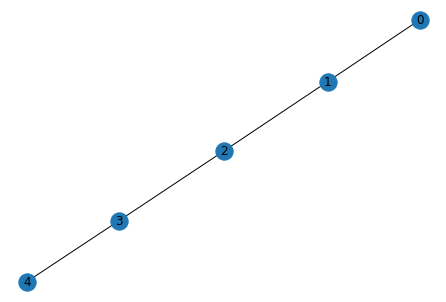

In [283]:
np.random.seed(seed=3)

# linear 5 node graph
set_edges = [
     (0, 1, 1),
     (1, 2, 1), 
     (2, 3, 1), 
     (3, 4, 1), 
    ]

def draw_graph(edges):
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    
    nx.draw(G, with_labels=True)
    plt.show()

draw_graph(set_edges)

# Create QAOA circuit

As many quantum algorithm we will our initial state will be the superposition of all the qubits.

In [284]:
def initialization(qubits):
    for q in qubits:
        yield cirq.H.on(q)

Now, we can define our cost and mixer Hamiltonian: $H_C, H_X$.

In [285]:
#### No se perque ho divideix per math.pi CANVIAR
def cost_unitary(qubits, gamma): 
    for start_node, end_node, weight in set_edges:                
        yield cirq.ZZPowGate(exponent=-weight*gamma/math.pi).on(qubits[start_node], qubits[end_node])
        

def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent=-alpha/math.pi).on(qubits[i])

Combining the initial state, cost and mixer functions we can create a QAOA circuit.

In [286]:
def qaoa_circuit(qubits, alpha: list, gamma: list , depth: int):
    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    
    for depth_level in range(0, depth): # CANVIAR gamma i alpha, per alpha i beta
        circuit.append(cost_unitary(qubits, gamma[depth_level]))
        circuit.append(mixer_unitary(qubits, alpha[depth_level]))
    circuit.append(cirq.measure(*qubits, key='x'))
    
    return circuit

In [287]:
def get_samples(circuit, repetitions: int):
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=repetitions)
    results = str(results)[2:].split(", ")
    num_qubits = len(results)
    samples = list()
    
    # sorting results
    for rep in range(0, repetitions):
        bitstring = list()
        for qubit in range(0, num_qubits): 
            bitstring.append(int(results[qubit][rep]))
        samples.append(bitstring)
        
    return samples

In [288]:
def cost_function(params, qubits, depth, repetitions, set_edges):
    gamma = params[:len(params)//2]
    alpha = params[len(params)//2:]
    
    circuit = qaoa_circuit(qubits, gamma, alpha, depth)
    samples = get_samples(circuit, repetitions)
    
    cost = 0
    for sample in samples:
        for start_node, end_node, weight in set_edges:
            Z_i = (1 - 2*sample[start_node])
            Z_j = (1 - 2*sample[end_node])
            cost += 0.5*weight*(1 - Z_i * Z_j)
    # average cost    
    total_cost = float(cost)/len(samples)
    
    return -total_cost # EXPLICAR         

In [289]:
def optimal_params(objective_func, qubits, depth, repetitions, set_edges):
    init_param = [float(np.random.randint(-314, 314))/float(100) for i in range(0, 2*depth)]
    result = minimize(objective_func, x0=init_param, args=(qubits, depth, repetitions, set_edges), method='COBYLA', options={'maxiter':100})    
    optimal_gamma = result['x'][:len(result['x'])//2]
    optimal_alpha = result['x'][len(result['x'])//2:]
    return optimal_gamma, optimal_alpha

aqui explicam que es samples son [0,1,1,0,1] i que per determinar aixo en base decimal utilitzam sa formula d_o*2⁰ + d_1*2¹...

In [290]:
def state_and_probs(qubits, opt_gamma, opt_alpha, depth, repetitions):
    opt_circuit = qaoa_circuit(qubits, opt_gamma, opt_alpha, depth)
    samples = get_samples(opt_circuit, repetitions)
    
    states = set()
    freqs = np.zeros(2**len(qubits))
    for sample in samples:
        state = 0
        for qubit_position, qubit in enumerate(sample):
            state += 2**(len(sample)-qubit_position-1)*qubit 
        
        states.add(state)
        freqs[state] += 1
        
    probs = freqs/np.sum(freqs)
    return states, probs
        

def plot_bitstrings_probs(probs, num_qubits):
    x = range(0, 2**num_qubits)
    plt.bar(x, probs)
    plt.show()  

# Results

As we saw at the beginning we want to find the best cut for the following graph.

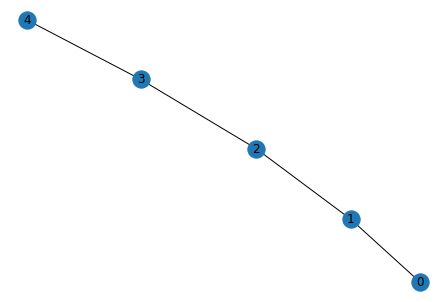

In [291]:
# linear 5 node graph
set_edges = [(0, 1, 1),(1, 2, 1), (2, 3, 1), (3, 4, 1)]
draw_graph(set_edges)

So, since there are 5 nodes, we will need 5 qubits. We also use a circuit with depth 4 to establish a comparision with the code written by [lucaman99](https://lucaman99.github.io/new_blog/2020/mar16.html).  

For more information regarding to the depth, check this [blog](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained).

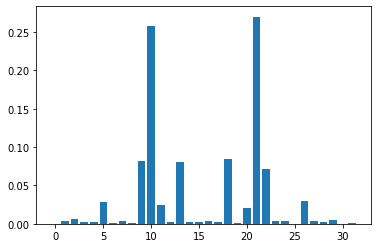

In [294]:
# Parameters
num_qubits = 5 
depth = 4
repetitions = 1000

# Defining a list of qubits
qubits = [cirq.GridQubit(0, i) for i in range(0, num_qubits)]

# Compute the optimal gamma and alpha
opt_gamma, opt_alpha = optimal_params(cost_function, qubits, depth, repetitions, set_edges)

# Compute all possible states and its probabilities
states, probs = state_and_probs(qubits, opt_gamma, opt_alpha, depth, repetitions)

# Visualize results
plot_bitstrings_probs(probs, num_qubits)

# Plotting max-cut graph

In [295]:
def max_cut_graph(probs, set_edges, reverse=False):
    most_prob_state = np.argmax(probs)
    bitstring = bin(most_prob_state)[2:]

    G = nx.Graph()
    G.add_weighted_edges_from(set_edges)
    
    colors = list()
    if reverse:
        bitstring = bitstring[::-1]
    
    for node in G:
        if bitstring[node] == str(1):
            colors.append("blue")
        else:
            colors.append("red")

    nx.draw(G, node_color = colors, with_labels=True)
    plt.show()

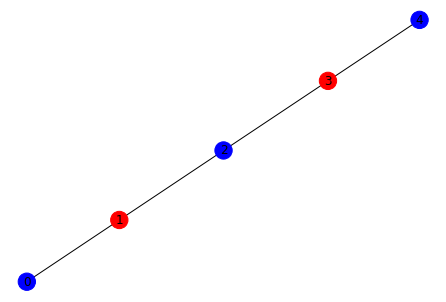

In [296]:
max_cut_graph(probs, set_edges)

# Weighted graph

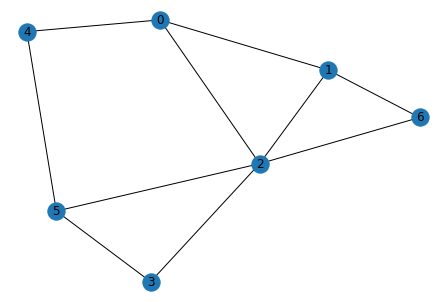

In [297]:
edges_weighted = [
    (0, 1, 2),
    (0, 2, 1),
    (2, 3, 2),
    (0, 4, 4),
    (2, 5, 1),
    (1, 2, 3),
    (1, 6, 5),
    (2, 6, 2),
    (3, 5, 3),
    (4, 5, 1)
]

draw_graph(edges_weighted)

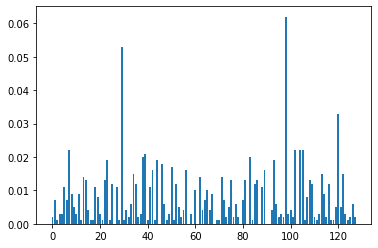

In [341]:
# Parameters
num_qubits = 7 
depth = 4
repetitions = 1000
set_edges = edges_weighted

# Defining a list of qubits
qubits = [cirq.GridQubit(0, i) for i in range(0, num_qubits)]

# Compute the optimal gamma and alpha
opt_gamma, opt_alpha = optimal_params(cost_function, qubits, depth, repetitions, set_edges)

# Compute all possible states and its probabilities
states, probs = state_and_probs(qubits, opt_gamma, opt_alpha, depth, repetitions)

# Visualize results
plot_bitstrings_probs(probs, num_qubits)

In [342]:
np.argmax(probs)

98

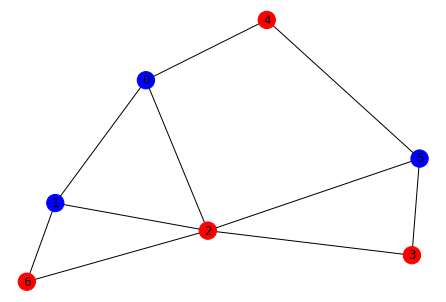

In [343]:
max_cut_graph(probs, set_edges)

## Next steps:
* Adding Documentation
* Adding more examples, to test the code.
* Draw weighted graphs using netwokx.
* Try different depths.
* Try to implement others code:
[Guilleaume](https://colab.research.google.com/drive/1yFIzqXWDwWe1l1c5ATFhuFcmDQiQUk25#scrollTo=Hf2oywn3HlrC),
[Qiskit](https://qiskit.org/textbook/ch-applications/qaoa.html),
[Qiskit_2](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html),
[Cirq](https://quantumai.google/cirq/tutorials/qaoa).


Comment: If the final state is not the expected, you might try running again the code. I need to figure out a way to get more stable solution, perhaps doing more repetition or modifing the depth of the circuit. 
